In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from lane_detection import *
%matplotlib inline
%load_ext autoreload

In [2]:
# some test images
images = np.array([plt.imread(i) for i in glob.glob('./test_images/*.jpg')] 
                  + [plt.imread(i) for i in glob.glob('./problem_frames/problem_frame*.jpg')])
# calibaration images
images_cal = np.array([plt.imread(i) for i in glob.glob('./camera_cal/*.jpg')])

image_size = (images[0].shape[1], images[0].shape[0])

In [3]:
# some parameters

mask_vertices = np.array([[[182, 720], [500, 466], [782, 464], [1234, 720]]]) # mask
c_thresh = [90,255] # threshhold in C color channel
gray_thresh = [200,217] # threshhold in gray channel
src = np.float32([[258, 679], [446, 549], [837, 549], [1045, 679]]) # perspective transform source
dst = np.float32([[258, 679], [258, 549], [837, 549], [837, 679]]) # perspective transform destionation
sliding_window=[80,120] # sliding window dimensions


## camera caliberation parameters ##

In [4]:
dist_mtx,dist_param = camera_cal_parameters(images_cal,image_size)

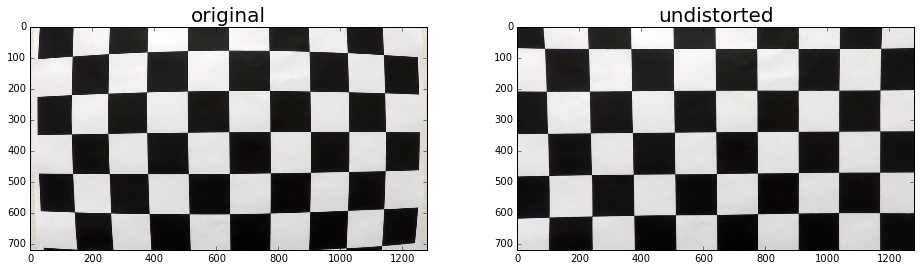

In [9]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (16,4))
ax1.imshow(images_cal[0])
ax1.set_title('original',fontsize=20)
ax2.imshow(undistort(images_cal[0],dist_mtx,dist_param))
ax2.set_title('undistorted',fontsize=20)

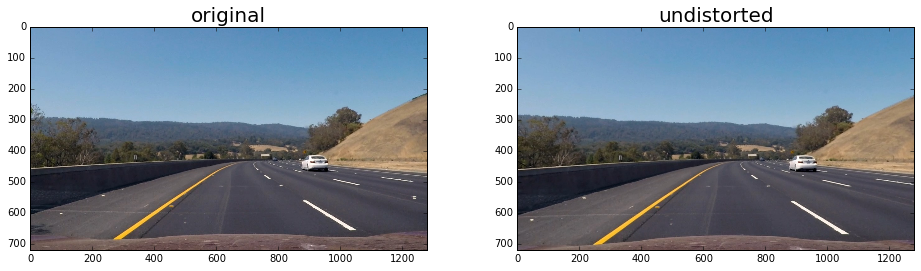

In [10]:
image = images[4]
image_undist = undistort(image,dist_mtx,dist_param)
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (16,4))
ax1.imshow(image)
ax1.set_title('original',fontsize=20)
ax2.imshow(image_undist)
ax2.set_title('undistorted',fontsize=20)

## image thresholding ##

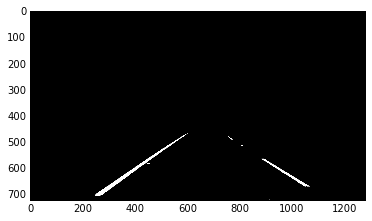

In [13]:
image_binary = preprocess(image_undist,mask_vertices=mask_vertices,c_thresh=c_thresh,gray_thresh=gray_thresh)
plt.imshow(image_binary,cmap='gray')

## perspective transformation ##

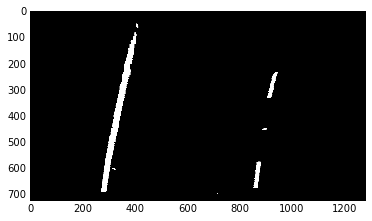

In [14]:
image_binary_bird = perspective_transform(image_binary,src,dst)
plt.imshow(image_binary_bird,cmap='gray')

## select left and right lane lines ##

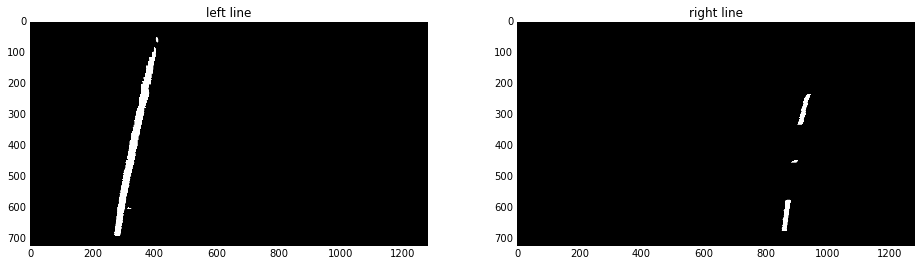

In [15]:
left_lane, right_lane = select_lane_lines(image_binary_bird)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.imshow(left_lane,cmap='gray')
ax1.set_title('left line')
ax2.imshow(right_lane,cmap='gray')
ax2.set_title('right line')

## fit lane line ##

In [16]:
left_fit,right_fit = fit_lane_line([left_lane,right_lane])

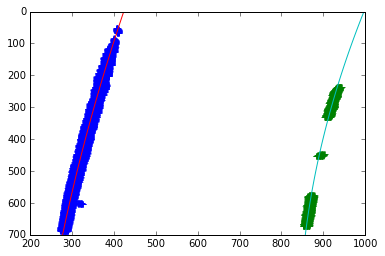

In [18]:
yval = np.linspace(0,700)

left_Y,left_X = np.where(left_lane==1)
left_fitx = left_fit[0]*yval**2 + left_fit[1]*yval + left_fit[2]

right_Y,right_X = np.where(right_lane==1)
right_fitx = right_fit[0]*yval**2 + right_fit[1]*yval + right_fit[2]

plt.plot(left_X,left_Y,'+')
plt.plot(right_X,right_Y,'+')
plt.plot(left_fitx,yval)
plt.plot(right_fitx,yval)
plt.gca().invert_yaxis()

## calculate curvature of the road ##

In [12]:
radius, deviation = cal_curvature([left_lane,right_lane])

## highlight lane in the original image ##

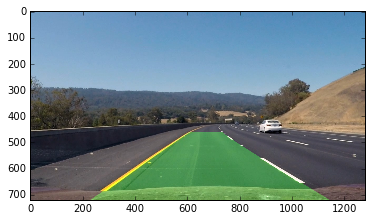

In [13]:
plt.imshow(draw_lane(image,[left_fit,right_fit],src,dst))

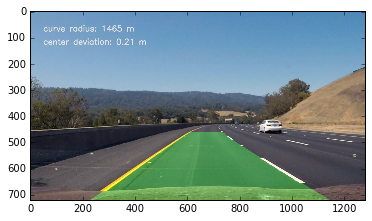

In [14]:
i2 = draw_lane(image,[left_fit,right_fit],src,dst)
plt.imshow(print_info(i2,radius,deviation))

## combine pipline ##

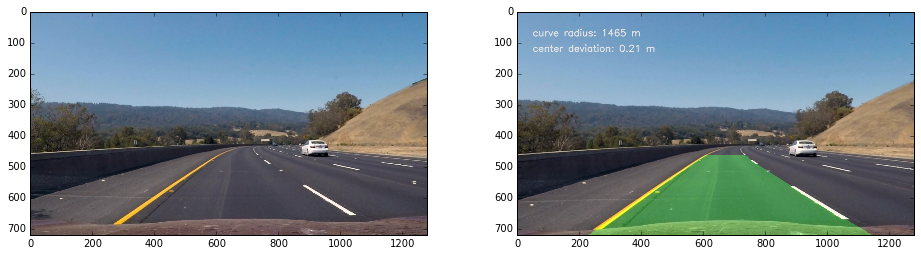

In [15]:
image_highlighted = lane_detection(image,dist_mtx=dist_mtx,dist_param=dist_param,mask_vertices=mask_vertices,
               c_thresh=c_thresh,gray_thresh=gray_thresh,src=src,dst=dst,sliding_window=sliding_window)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.imshow(image)
ax2.imshow(image_highlighted)

## process video ##

In [ ]:
def frame_func(image):
    return lane_detection(image,dist_mtx=dist_mtx,dist_param=dist_param,mask_vertices=mask_vertices,
               c_thresh=c_thresh,gray_thresh=gray_thresh,src=src,dst=dst,sliding_window=sliding_window)
    
project_video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
lane_clip = clip1.fl_image(frame_func) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(project_video_output, audio=False)